# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

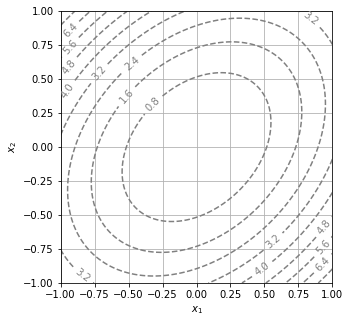

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    x = np.array(x)
    y = np.array(y)
    return (x - 1)**2 + (x - y**2)**2

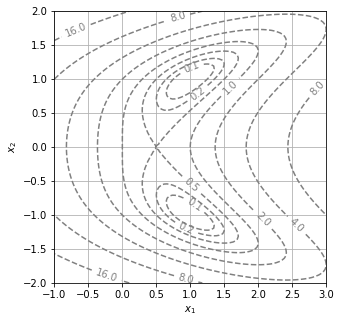

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    x = np.array(x)
    y = np.array(y)
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

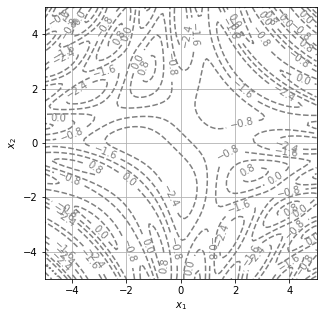

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [13]:
N = 100
eps = 10**(-7)

#on a d'une grande précision car on va faire tendre nos pas vers 0 

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [14]:
def Newton(F, x0, y0, eps=eps, N=N):
    J_F = J(F)
    x, y = x0, y0
    for i in range(N):
        H = np.linalg.solve(J_F(x, y), F(x, y))
        x -= H[0]
        y -= H[1]
        if np.sqrt(H[0]**2 + H[1]**2) <= eps:
            return x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [15]:
#test avec la courbe de niveau 0.8 de f1 en partant du point (0.8,0.8)

def F1(x,y):
    return np.array([f1(x,y)-0.8, y-x])

X = Newton(F1, .8, .8)
print(X)
f1(X[0], X[1])

(0.4472135954999579, 0.4472135954999579)


0.8

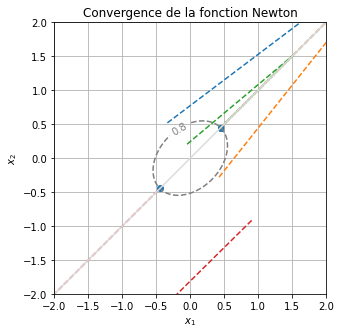

In [16]:
## Variation du point d'origine pour la courbe de niveau 0.8 de f1

# Pour suivre l'exécution, on considère une version modifiée qui renvoie les étapes successives

import random

def Newton_step(F, x0, y0, eps=eps, N=N):
    J_F = J(F)
    res_X, res_Y = [x0], [y0]
    for i in range(N):
        x, y = res_X[-1], res_Y[-1]
        H = np.linalg.solve(J_F(x, y), -F(x, y))
        x += H[0]
        y += H[1]
        res_X.append(x)
        res_Y.append(y)
        if np.sqrt(H[0]**2 + H[1]**2) <= eps:
            return np.array(res_X), np.array(res_Y)
    else:
        raise ValueError(f"no convergence in {N} steps.")
        
# On affiche les courbes de niveau 0.8 de f1 et la première bissectrice

t = np.linspace(-2, 2, 400)

display_contour(f1, t, t, [.8])

plt.title('Convergence de la fonction Newton')
plt.xlim(-2, 2)
plt.ylim(-2, 2)

        
# On va observer le comportement de Newton pour 4 points aléatoires de [-1, 1] x [-1, 1]

n = 4

sol = np.empty((n, 2))

for i in range(n):
    x0, y0 = 2*random.random() - 1, 2*random.random() - 1
    X, Y = Newton_step(F1, x0, y0)
    plt.plot(X, Y, '--');
    sol[i, :] = X[-1], Y[-1]

plt.scatter(sol[:, 0], sol[:, 1]); # ce sont les points solutions obtenus
plt.plot(t, t, label = "Première bissectrice", color = 'gainsboro')
plt.show()

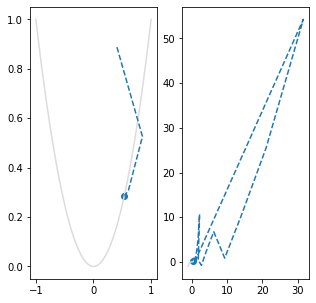

In [17]:
## On fait varier la contrainte

# On fait la même chose que précédemment mais avec les contraintes y = x**2 et y = x**3

def F_contrainteCarree(x, y):
    return np.array([f1(x,y)-.8, y - x**2])

def F_contrainteCube(x, y):
    return np.array([f1(x,y) - .8, y - x**3])

# On affiche les courbes associées à la contrainte considérée

fig, ax = plt.subplots(1, 2)

t = np.linspace(-1, 1, 200)

ax[0].plot(t, t**2, label = "Fonction carrée", color = 'gainsboro');
ax[1].plot(t, t**3, label = "Fonction cube", color = 'gainsboro');
        
# On va observer le comportement de Newton pour un point aléatoire de [-1, 1] x [-1, 1]

while True:
    x0, y0 = 2*random.random() - 1, 2*random.random() - 1
    try:
        Xc, Yc = Newton_step(F_contrainteCarree, x0, y0)
        Xk, Yk = Newton_step(F_contrainteCube, x0, y0)
        ax[0].plot(Xc, Yc, '--');
        ax[0].scatter(Xc[-1], Yc[-1]);
        ax[1].plot(Xk, Yk, '--');
        ax[1].scatter(Xk[-1], Yk[-1]);
        break
    except ValueError:
        pass

In [18]:
## On fait varier la fonction étudiée : nous allons faire un test similaire avec f3
## On prend la contrainte x = y et la courbe de niveau 0.8 en partant du point (0.1, 0.1)

def F3(x, y):
    return np.array([f3(x,y) - .8, y - x])

X = Newton(F3, .1, .1)
print(X)
f3(X[0], X[1])

(3.8760915758361993, 3.8760915758361993)


0.8000000000000008

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [19]:
#le gradient en x0 est orthogonal à la courbe 
#R=((0,−1),(1,0)) est la matrice de rotation d'angle −pi/2 : on tourne vers la droite 
#donc e=R⋅∇𝑓(x0) est le vecteur tourné vers la droite suivant la tangente à f
#on va donc projeter notre vecteur sur ce vecteur : p(x,y)=e.(x-x0,y-y0)

def projete(f, x0, y0, x, y):
    gradient = grad(f)(x0, y0)
    norme_gradient = np.sqrt(gradient.dot(gradient))
    gradient = gradient/norme_gradient #on normalise le gradient
    vecteur = np.array([y0 - y, x - x0]) #vecteur qui va de de (x0,y0) à (x,y) multiplié par la matrice de rotation
    return gradient.dot(vecteur)

In [20]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    
    res=np.zeros((2,N))
    res[0][0], res[1][0]=x0,y0
    x1,y1=x0,y0
    
    for k in range(1,N):
        
        def F(x,y):
            return np.array([projete(f,x1,y1,x,y)-delta, f(x,y)-f(x0,y0)]) #double contrainte : le projeté à droite est de norme delta et f(x,y)=c
        x,y = Newton(F, x1, y1)
        res[0][k], res[1][k]=x,y
        x1,y1=x,y
    
    return res

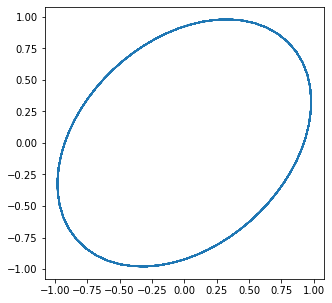

In [21]:
#on teste la fonction sur la fonction f1 en partant de (0.8,0.8)

X=level_curve(f1,.8,.8)

plt.plot(X[0,:], X[1,:])
plt.show()

#on voit que l'on est repassé plusieurs fois au même endroit


### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [22]:
def det(A, B, C): #renvoie le determinant de (AB→, AC→)
    v1,v2=[0,0],[0,0]
    v1[0], v2[0] = B[0] - A[0], C[0] - A[0]
    v1[1], v2[1] = B[1] - A[1], C[1] - A[1]
    return v1[0]*v2[1] - v1[1]*v2[0]

def in_seg(A, B, C): #renvoie true si A appartient au vecteur BC
    e = 10**(-8) # pour prendre en compte les erreurs d'arrondi
    v1,v2=[0,0],[0,0]
    v1[0], v2[0] = B[0] - A[0], C[0] - A[0]
    v1[1], v2[1] = B[1] - A[1], C[1] - A[1]
    return np.abs(det(A, B, C)) <= e and np.array(v1).dot(np.array(v2)) <= 0 #AB→ et AC→ sont des vecteurs opposés

#On crée la fonction intersection qui renvoie true si et seulement si les segements  [A,B] et  [C,D] s'intersectent
# la droite  (C,D) intersecte  ]A,B[ (le cas des extrêmités est traité dans alignement) si et seulement si 
#les angles  (CD→,CA→)et  (CD→,CB→)ont des orientations strictement opposés 
#donc si et seulement si  det(CD→,CA→)det(CD→,CB→)<0

def intersection(A, B, C, D):
    e = 10**(-8)
    alignement = in_seg(A, C, D) or in_seg(B, C, D) or in_seg(C, A, B) or in_seg(D, A, B)
    c1, c2 = det(A, B, D), det(A, B, C)
    d1, d2 = det(D, C, A), det(D, C, B)
    return (c1*c2 < 0 and d1*d2 < 0) or alignement

In [23]:
def level_curve_nouveau(f, x0, y0, delta=0.1, N=1000, eps=eps):
    
    res=np.zeros((2,N))
    res[0][0], res[1][0]=x0,y0
    x1,y1=x0,y0
    
    for k in range(1,N):
        
        def F(x,y):
            return np.array([projete(f,x1,y1,x,y)-delta, f(x,y)-f(x0,y0)]) 
        #la condition est que le projeté suivant la tangente à droite doit être à une distance delta de (x0,y0)
        
        x,y = Newton(F, x1, y1)
        res[0][k], res[1][k]=x,y
        
        if k>2 and intersection (res[:, 0], res[:,1],[x1,y1],[x,y]): #k>2 car les deux premiers points sont égaux
            return res[:,:k+1] #on ne retourne que la partie intéressante, cad avant l'intersection
        
        x1,y1=x,y
    return res

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

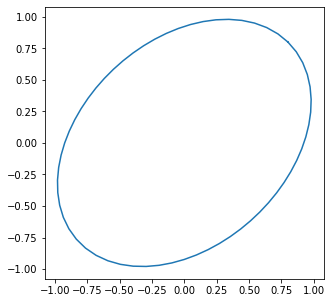

In [24]:
#courbe de niveau f1(0.8,0.8) de la fonction f1

x0,y0=.8,.8
X = level_curve_nouveau(f1, x0, y0)

plt.plot(X[0, :], X[1, :])

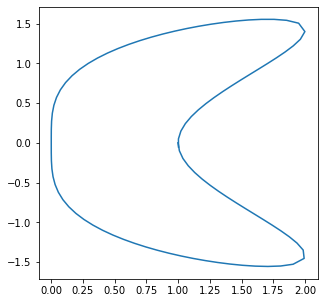

In [25]:
#courbe de niveau f2(1,2) de la fonction f2

X = level_curve_nouveau(f2, 1., 0.)

plt.plot(X[0, :], X[1, :])

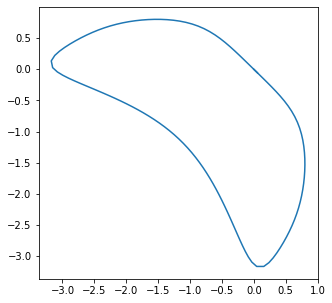

In [26]:
#courbe de niveau f3(0,0) de la fonction f3

X = level_curve_nouveau(f3, 0., 0.)

plt.plot(X[0, :], X[1, :]);

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [27]:
# Déterminer le grand carré

def bigger_square(f, c):

    # Trouver un point de la courbe : on en prend un tel que x=y

    def F(x,y):
        return np.array([f(x,y) - c, y-x])

    x0, y0 = Newton(F, 1., 0., N=10000)

    assert np.abs(f(x0, y0) - c) <= 10**-5 #on vérifie que f(x0,y0)=c

    # Courbe de niveau partant de (x0,y0)

    P = level_curve_nouveau(f, x0, y0)
    xc, yc = P[0, :].mean(), P[1, :].mean() #coordonnées du centre du carré

    dist = np.power(P[0, :] - xc, 2) + np.power(P[1, :] - yc, 2) #distances de tous les points au centre du carré

    return xc, yc, np.max(dist) # Centre et demi-côté du grand carré

def area_squares(f,c,h):
    xc, yc, L = bigger_square(f, c)
    n=int(L/h)+1
    count=0
    for i in range (-n,n):
        
        for j in range(-n,n):
            xi= xc + h*(i + .5)
            yj= yc + h*(j + .5)
            
            if f(xi,yj) <=c: #on regarde si le centre du carré vérifie la condition
                count+=1 
                
    return count * (h**2)

In [28]:
#on essaye avec le disque unité

def disque_unité(x,y):
    return (np.sqrt(x**2+y**2))

area_squares(disque_unité,1,.01)

#valeur proche de pi : méthode valide

3.1413

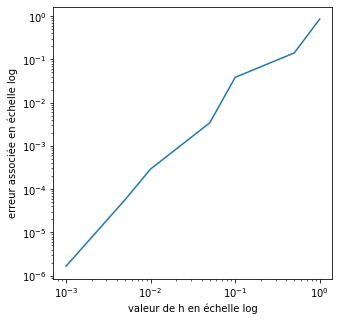

In [29]:
def erreur_disque_unité (h):
    return abs(area_squares(disque_unité,1,h)-np.pi)

h=[1, 0.5,0.1,0.05,0.01, 0.005, 0.001]
#x=[1,0.6,0.3,0.25,0.1,0.03,0.02,0.01, 0.001]
y=[erreur_disque_unité(z) for z in h]
plt.loglog(h, y)
plt.xlabel("valeur de h en échelle log")
plt.ylabel("erreur associée en échelle log")
plt.show() 

#on voit que plus le pas h est petit, plus la précision est grande
# plus précisément : pour h= 10^-1, l'erreur est de 3.10^-2, mais pour un pas h= 10^-2, l'erreur est de 3.10^-4 
# donc la précision est exponentiellement grande par rapport au pas h
#cela nous est prouvé par le fait que la courbe est une demi-bissectrice en échelle loglog

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [30]:
#pour obtenir un encadrement, on prend les carrés qui sont strictement inclus dans l'ensemble de sous niveau (minoration de l'aire)
# et ceux à la frontière de ceux inclus dans l'ensemble de sous niveau (majoration de l'aire)

def encadrement(f,c,h):
    xc, yc, L = bigger_square(f, c)
    n=int(L/h)+1
    count_inf=0 #minoration
    count_sup=0 #majoration
    for i in range (-n,n):
        
        for j in range(-n,n):
            xi= xc + h*i
            xi1= xc + h*(i+1) #abscisse à droite
            yj= yc + h*j
            yj1= yc + h*(j+1) #ordonnée en dessous
            
            if f(xi,yj) <=c and f(xi1,yj)<=c and f(xi1,yj1)<=c and f(xi,yj1)<=c: #on regarde si les 4 sommets du carré vérifient la condition
                count_inf+=1 
                count_sup+=1
                
            elif f(xi,yj) <=c or f(xi1,yj)<=c or f(xi1,yj1)<=c or f(xi,yj1)<=c: #si au moins un des sommets vérifie, on l'ajoute dans count_sup (il se trouve donc sur la frontière)
                count_sup+=1     
    return count_inf*(h**2), count_sup*(h**2)

In [31]:
encadrement(disque_unité,1,0.002)

#on obtient un encadrement à 10^-2 près pour un pas h=2.10^-3

(3.133556, 3.149556)

In [32]:
3.149556-3.133556

#précision à 10^-2

0.016000000000000014

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [33]:
def pv(x,y): #renvoie le produit vectoriel entre x et y
    x1,x2=x
    y1,y2=y
    
    return (x1*y2-y1*x2)

In [34]:
def vec(x,y): #renvoie le vecteur qui va de x vers y
    x1,x2=x
    y1,y2=y
    
    return ((y1-x1),(y2-x2))

In [35]:
def aire_triangle(a,b,c): #renvoie l'aire du triangle de sommets a,b,c
    
    return pv(vec(a,b), vec(a,c))/2

In [36]:
#implémentation de BN

def B(liste,p): #prend en argument une liste de points (x0,y0), (x1,y1)... et le point p 
    aire=0
    for i in range(len(liste[0])-1):
        aire+=aire_triangle(p,liste[:,i+1], liste[:,i])
    
    return aire

In [37]:
#on teste sur le cercle unité

suite=level_curve_nouveau(disque_unité, 1., 0., delta=0.1, N=1000, eps=eps)
B(suite, (0.5,0))

#on obtient une valeur proche de pi

3.1431602970460277

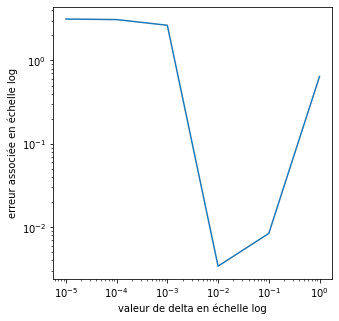

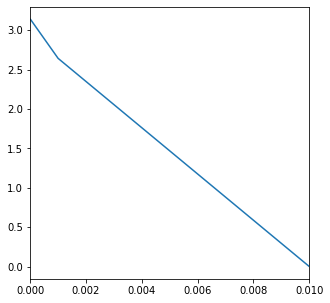

In [38]:
#fonction qui renvoie l'erreur sur la valeur de pi

def convergencepi (delta):
    suite=level_curve_nouveau(disque_unité, 1., 0., delta=delta, N=1000, eps=eps)
    return abs(B(suite, (0,0))-np.pi)

#on va tracer l'erreur pour différentes valeurs de delta

delta=[1,0.1,0.01,0.001,0.0001,0.00001]
y=[convergencepi(z) for z in delta]

#d'abord en échelle log

plt.loglog(delta, y)
plt.xlabel("valeur de delta en échelle log")
plt.ylabel("erreur associée en échelle log")
plt.show()

#puis en échelle normale en zoomant sur la partie où l'erreur diverge

plt.plot(delta, y)
plt.xlim(0,0.01)
plt.show() 

#on remarque que la précision ne devient plus pertinente au dela d'une certaine valeur de delta (10^-2)
#on peut l'expliquer par le fait que les triangles deviennent trop petits 
#donc les aires tendent vers 0
#et donc les approximations faites par le programme ne sont plus pertinentes

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [39]:
#on teste avec un point en dehors du cercle unité centré en (0,0) : le point (1,1)

suite=level_curve_nouveau(disque_unité, 1., 0., delta=0.1, N=1000, eps=eps)
B(suite, (1,1))

#la valeur obtenue est 3.13, qui est assez proche de pi
#ce comportement peut être expliqué par le fait que 
#lorsque l'on repasse en sens inverse devant le point, les aires se compensent entre elles

3.1365077552673544

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

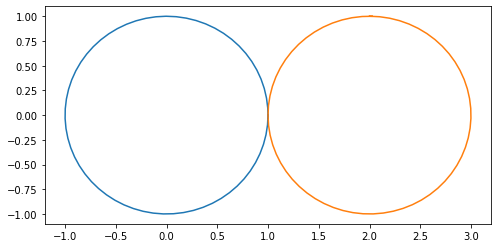

6.313866567083248

In [40]:
#pour un ensemble non convexe

#fonction qui code le disque unité centré en (2,0)

def disque_1(x,y):
    return np.sqrt((x-2)**2+y**2)

#suite de points du cercle unité centré en (0,0)
suite=level_curve_nouveau(disque_unité, 1., 0., delta=0.1, N=1000, eps=eps)

#suite de points du cercle unité centré en (2,0)
suite2=level_curve_nouveau(disque_1, 2., 1., delta=0.1, N=1000, eps=eps) 

#réunion des deux
suite3=suite+suite2 


#on trace la figure 

plt.figure(figsize=(8,4))
plt.plot(suite[0,:],suite[1,:])
plt.plot(suite2[0,:],suite2[1,:])
plt.show()

#aire obtenue pour cette figure
B(suite3,(1,0))

#la valeur obtenue est 6.31 qui est très proche de 2pi : donc cela fonctionne

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [41]:
#suite désigne la liste des points (xi,yi)

def area_triangles (suite):
    p=(suite[0,0], suite[0,0]) #on prend comme point p le premier point de la liste
    return B(suite,p)

#on compare les deux techniques

#courbe de niveau f1(.8,.8) de f1

print('technique des triangles')
print(area_triangles (level_curve_nouveau(f1, .8, .8))) 
print('technique des carrés')
print(area_squares(f1,f1(.8,.8),0.1))
print('\n')

#courbe de niveau f2(2.,1.) de f2

print('technique des triangles')
print(area_triangles (level_curve_nouveau(f2, 2., 1.)))
print('technique des carrés')
print(area_squares(f2,f2(2.,1.),0.1))
print('\n')

#courbe de niveau f2(0.,1.) de f2

print('technique des triangles')
print(area_triangles (level_curve_nouveau(f2, 0., 1.)))
print('technique des carrés')
print(area_squares(f2,f2(0,1),0.1))
print('\n')

#courbe de niveau f1(1.,1.) de f1

print('technique des triangles')
print(area_triangles (level_curve_nouveau(f1, 1., 1.)))
print('technique des carrés')
print(area_squares(f1,f1(1,1),0.1))
print('\n')

#les résultats semblent cohérents entre eux pour f1 et f2

technique des triangles
2.838186009914193
technique des carrés
2.880000000000001


technique des triangles
6.128811799759912
technique des carrés
6.130000000000001


technique des triangles
6.130568097780735
technique des carrés
6.130000000000001


technique des triangles
4.437589592231149
technique des carrés
4.430000000000001




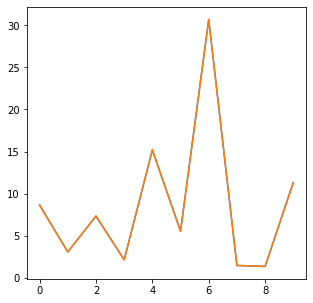

In [47]:
#pour un test plus précis, on trace les aires pour différents points au hasard dans [-2,2]x[-2,2]

n=10
y1=[]
y2=[]

for i in range(n):
    x, y = 4*random.random() - 2, 4*random.random() - 2
    y1.append(area_triangles (level_curve_nouveau(f1, x,y)))
    y2.append(area_squares(f1,f1(x,y),0.1))

plt.plot(np.arange(n), y1, y2)
plt.show()

#les courbes sont superposées : les aires sont très proches pour les deux méthodes
#les deux méthodes sont cohérentes

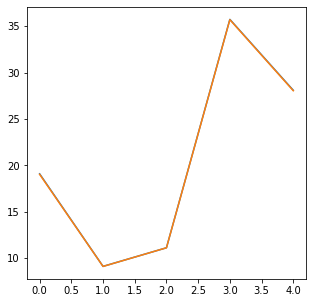

In [43]:
#de même avec f2 pour des points dans [-2,0]x[-2,0]

n=5
y1=[]
y2=[]

for i in range(n):
    x, y = 2*random.random()-2, 2*random.random()-2
    y1.append(area_triangles (level_curve_nouveau(f2, x,y)))
    y2.append(area_squares(f2,f2(x,y),0.1))

plt.plot(np.arange(n), y1, y2)
plt.show()

#les courbes sont superposées : les deux méthodes sont cohérentes

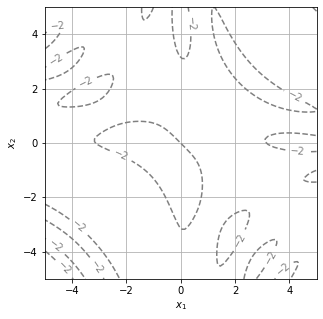

In [44]:
#courbe de niveau f3(0.,0.) pour f3

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=[f3(0,0)])

In [45]:
#courbe de niveau f3(0,0) de f3

print('méthode des triangles')
print(area_triangles (level_curve_nouveau(f3, 0., 0.)))
print('méthode des carrés')
print(area_squares(f3,f3(0,0),0.1))

#les deux résultats sont incohérents pour la courbe de niveau de f3

#explication : pour la fonction f3, les points qui vérifient f(x,y)<=c forment un ensemble non connexe
#la fonction area_squares, elle, va prendre en compte tous les points qui vérifient la condition

#la fonction level_curve, elle, va produire une suite de points qui 
#forment un seul ensemble connexe (celui qui se trouve au milieu de la figure précédente)
#donc area_triangles ne va calculer que l'aire de la figure qui se trouve au milieu

méthode des triangles
7.052769948539465
méthode des carrés
32.540000000000006


In [46]:
#avantage de square : une grande précision (précision exponentielle par rapport au pas)
# de plus on peut calculer des aires non connexes, et aussi non convexes

#inconvénient de square : si l'ensemble est très grand, on ne peut pas le calculer car cela demanderait un 
#carré très grand, et donc une infinité de calculs


#avantage de triangles : on peut calculer des ensembles de niveaux (mêmes très grand) tant qu'ils sont connexes
#on peut partir d'un point extérieur à l'ensemble de niveau
#on peut calculer des aires non convexes

#inconvénient des triangles : une précision limitée car quand delta tend vers 0, les aires des triangles tendent vers 0 
#donc on somme des aires qui tendent vers 0 : les arrondis ne se font pas correctement